**IMPORTING MODULES**


In [1]:
import numpy as np
import gdal
import skimage

In [2]:
import deepgeo.common.geofunctions as gf
import deepgeo.common.visualization as vis
import deepgeo.dataset.dataset_generator as dg
import deepgeo.dataset.preprocessor as prep
import deepgeo.dataset.sequential_chips as seqchips
import deepgeo.networks.model_builder as mb
from deepgeo.dataset import rasterizer

**DEFINING INPUT FILES**

In [3]:
#zip_file = 'FULL_AREA_S2_2018.zip'

In [4]:
#Unzip a zip file
#import zipfile
#with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    #zip_ref.extractall('Full_Area_S2_2018')


In [3]:
local_dir = 'Full_Area_S2_2020/FULLAREA_S2_2020'
raster_file = 'Full_Area_S2_2020/FULLAREA_S2_2020/Chips_S2_2020.tif'
shape_file = 'Full_Area_S2_2020/FULLAREA_S2_2020/Samples_S2_2020.shp'

**VISUALIZING RASTER IMAGE**

In [4]:
img_raster = gf.load_image(raster_file, no_data = 0)
#investige max and min DN value
max_img_raster = np.amax(img_raster)
min_img_raster = np.amin (img_raster)

print('max DN value =', max_img_raster, 'min DN value =', min_img_raster)

max DN value = 1.5295 min DN value = 1e-04


ValueError: Images of type float must be between -1 and 1.

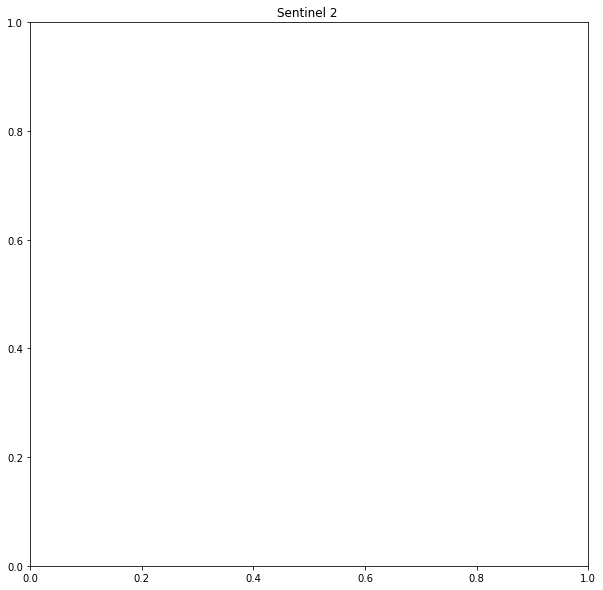

In [8]:
vis.plot_rgb_img(img_raster, bands=[0, 5, 2 ], contrast=True, title="Sentinel 2 ")

**RASTERIZING SHAPE FILE**

In [10]:
classes_of_interest = ['bare land', 'natural forest', 'other land cover','oil palm', 'water']
non_class = 'cloud'
class_column = 'landcover'
out_labels = 'Full_Area_S2_2020/FULLAREA_S2_2020/labels.tif'

In [6]:
rstzr = rasterizer.Rasterizer(shape_file, 
                              raster_file,
                              class_column,
                              classes_interest=classes_of_interest,
                              non_class_name=non_class)

In [7]:
rstzr.collect_class_names()
rstzr.rasterize_layer()
class_names = ['no_data'] + rstzr.get_class_names() 
rasterized_layer = rstzr.get_labeled_raster()

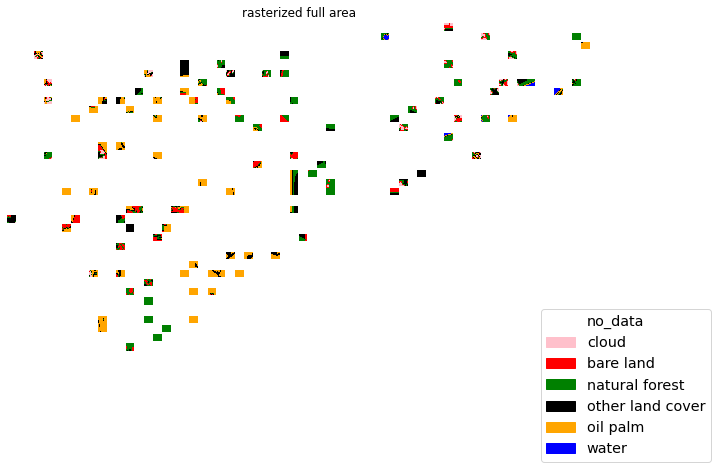

In [8]:
#Visualizing rasterized shape file
vis.plot_labels(rasterized_layer,class_names, colors=['white','pink', 'red', 'green', 'black', 'orange', 'blue'] ,title = 'rasterized full area')

In [11]:
#save the rasterized layer
rstzr.save_labeled_raster_to_gtiff(out_labels)

**GENERATING TRAINING DATASET**

In [12]:
output_ds = 'Full_Area_S2_2020/FULLAREA_S2_2020/dataset'
ds_file_name = 'def_dataset'

In [13]:
dataset_description = {'years': 2020, 
                       'standardization': 'norm_range',
                       'range': {"min":0, "max":1},
                       'indexes_to_compute': 'none',
                       'bands': ['green', 'red', 'red_edge1', 'red_edge2', 'red_edge3', 'NIR','red_edge4', 'SWIR-1', 'SWIR-2'], #name of band in your image
                       'sensor': 'Sentinel 2', 
                       'classes':class_names,
                       'img_no_data': 0,
                       'chip_size': 300,
                       'tolerance_nodata': 0.2,
                       'notes': 'S2 2020'}

In [4]:
preproc = prep.Preprocessor(raster_file, no_data = 0)
#preproc.remove_bands(0)
#preproc.set_nodata_value(dataset_description['img_no_data'])


In [5]:
#preproc.standardize_image(dataset_description['standardization'], dataset_description['range'])
raster_img = preproc.get_array_stacked_raster()

In [6]:
np.shape(raster_img)

(10799, 19199, 9)

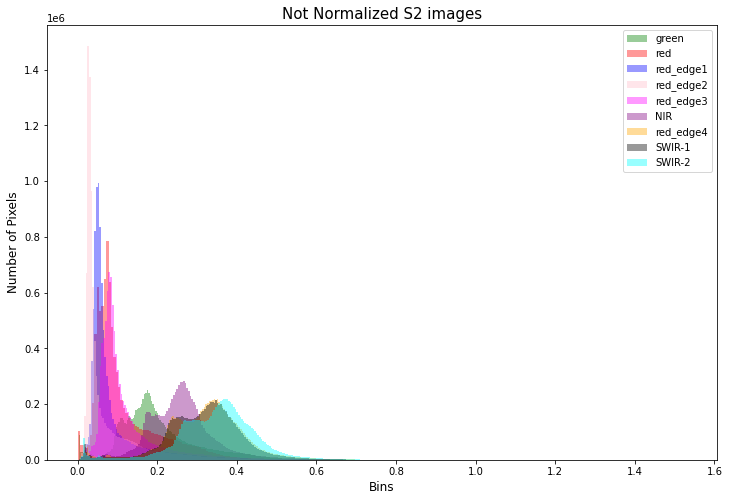

In [16]:
vis.plot_image_histogram(preproc.get_array_stacked_raster(), cmap=["green", "red", "blue", 'pink', 'magenta', 'purple', 'orange', 'black', 'cyan' ],
                         title="Not Normalized S2 images", legend=dataset_description['bands'])

  -> Generating chips...
  -> Removing no data chips...


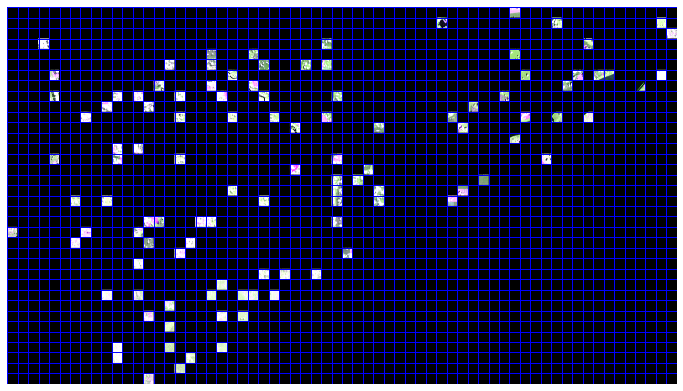

In [17]:
#Generating chips
generator = dg.DatasetGenerator([raster_img], 
                                [rasterized_layer],
                                #strategy='random',
                                strategy='sequential',
                                description=dataset_description)
params = {'win_size': dataset_description['chip_size'],
           'class_of_interest': classes_of_interest,
           #'quantity': 100, 
          'class_names':class_names}
generator.generate_chips(params)
chip_struct = generator.get_samples()
vis.plot_chips(chip_struct, raster_img, bands=[0, 5, 1], contrast=True)
generator.remove_no_data(tolerance=dataset_description['tolerance_nodata'])

In [18]:
generator.shuffle_ds()
#generator.split_ds(perc_test=20, perc_val=5) #splitting chips over study area to test and validation

  -> Shuffling Dataset...


In [19]:
generator.split_ds(perc_test=20, perc_val=1) #splitting chips over study area to test and validation

  -> Splitting Dataset...


In [20]:
chip_struct = generator.get_samples()
generator.save_to_disk(output_ds, ds_file_name)

  -> Saving Datasets to disk...
  -> DONE!
